#`This notebook is an Illustration to create a simpleRNN Model which is used for Fake News Detection with Sklearn and NLTK using Python 🐍`

For more information, check out [NLTk](https://www.nltk.org/).


## **Setup**
Let's setup the imports and download the packages required:   

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
 



In [2]:
nltk.download('stopwords') 
nltk.download('stem') 
nltk.download('wordnet')  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading stem: Package 'stem' not found in index
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Let's download the Fake News dataset which is uploaded on my google drive:

In [3]:
!gdown --id 1fpjTnS50qX8HycGXhC0Yk4tjn8wpZ8wr

Downloading...
From: https://drive.google.com/uc?id=1fpjTnS50qX8HycGXhC0Yk4tjn8wpZ8wr
To: /content/train.csv
98.6MB [00:00, 212MB/s]


Let's read the CVS file: 

In [4]:
df = pd.read_csv('/content/train.csv')

First few rows in the DataFrame:  

In [5]:
df.head() 

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


Let's see if we have any null values: 

In [6]:
df.isnull().sum() 

id           0
title      558
author    1957
text        39
label        0
dtype: int64

Looks like we have a few null values, Let's drop those values:

In [7]:
# Drop nan values
df = df.dropna()  

In [8]:
# Getting independent features
X = df.drop('label', axis=1) 

In [9]:
# Getting dependent features
Y = df['label']  

In [10]:
X.shape

(18285, 4)

In [11]:
Y.shape

(18285,)

Let's reset the index after removing the null Values:

In [12]:
messages = X.copy()  
messages.reset_index(inplace=True) # Resetting index after applying dropnan function 

Let's use NLTKs' WordLemmatizer which lemmatizes the words in the corpus and do some preprocessing also:

In [13]:
# Data Preprocessing
wordnet=WordNetLemmatizer() 
corpus = [] 
for i in range(0, len(messages)):
    #print(i) 
    review = re.sub('[^a-zA-Z]', ' ', messages ['title'][i]) 
    review = review.lower() 
    review = review.split() 
    
    review = [wordnet.lemmatize(word) for word in review if not word in stopwords.words('english')] # If word not in stopwords, 
    #we stem that word. All the stopwords are removed 
    review = ' '.join(review) # join all the list of words 
    corpus.append(review)  # appending into empty list 

## OneHot Representation

In [14]:
voc_size = 15000
onehot_rep = [one_hot(words, voc_size) for words in corpus] 
#print(onehot_rep)  

## Padding 

In [15]:
# Converts all the sentances to a fixed and equal lenght
sent_lenght = 60
embedded_docs = pad_sequences(onehot_rep, padding='post', maxlen = sent_lenght) # padding='pre'
embedded_docs 

array([[13909,  1574,    45, ...,     0,     0,     0],
       [13070, 12632,  6784, ...,     0,     0,     0],
       [ 5638,  1203, 11768, ...,     0,     0,     0],
       ...,
       [10601,  6205,  9646, ...,     0,     0,     0],
       [12090,  1769, 13750, ...,     0,     0,     0],
       [ 9624,  5824,   742, ...,     0,     0,     0]], dtype=int32)

In [16]:
len(embedded_docs)  

18285

## Simple RNN Model

In [17]:
# Creating model
embedding_vector_feature = 40
model = Sequential() 
model.add(Embedding(voc_size, embedding_vector_feature, input_length=sent_lenght))
model.add(Dropout(0.3))
model.add(SimpleRNN(64)) 
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5))) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary() 
model.output_shape 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 40)            600000    
_________________________________________________________________
dropout (Dropout)            (None, 60, 40)            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                6720      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 606,785
Trainable params: 606,785
Non-trainable params: 0
_________________________________________________________________


(None, 1)

In [18]:
#print(model.predict(embedded_docs))

converting the text arrays to numpy arrays:

In [19]:
x_final = np.array(embedded_docs) 
y_final = np.array(Y)   

Let's split out Dataset:

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, random_state=0, test_size=0.1)  

Fit Method:

In [21]:
model.fit(x_train, y_train, epochs=2, validation_data=(x_test, y_test), batch_size=32)  

Epoch 1/2
515/515 [==============================] - 11s 21ms/step - loss: 0.3366 - accuracy: 0.8627 - val_loss: 0.2472 - val_accuracy: 0.9054
Epoch 2/2
515/515 [==============================] - 11s 21ms/step - loss: 0.1934 - accuracy: 0.9343 - val_loss: 0.2831 - val_accuracy: 0.8808


Evaluation Metric:

In [22]:
model.evaluate(x_test, y_test) 

58/58 [==============================] - 0s 4ms/step - loss: 0.2831 - accuracy: 0.8808


[0.28305497765541077, 0.8808091878890991]

## Confusion Matrix

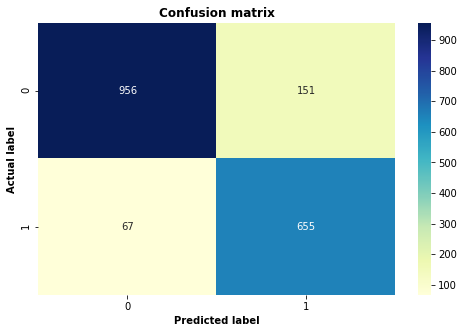

In [26]:
y_pred = model.predict_classes(x_test)  
cm = confusion_matrix(y_pred, y_test) 
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm, annot = True, cmap = 'YlGnBu', fmt='g'); 
plt.title('Confusion matrix', fontweight='bold')
plt.ylabel('Actual label', fontweight='bold')
plt.xlabel('Predicted label', fontweight='bold'); 

## Classification Report

In [27]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.93      0.86      0.90      1107
           1       0.81      0.91      0.86       722

    accuracy                           0.88      1829
   macro avg       0.87      0.89      0.88      1829
weighted avg       0.89      0.88      0.88      1829



## Accuracy Score

In [28]:
accuracy_score(y_pred, y_test)  

0.8808091853471842

## Summary

You now have learned to:

* Scratch Level understanding of How Text is converted to Vectors
* Intuitively understand what SimpleRNN is
* Preprocess data for the classifier
* Visualize Model Metrics


## Refernces:
- [NLTK](https://www.nltk.org/)
- [RNN](https://www.tensorflow.org/guide/keras/rnn)
- [Paper](https://arxiv.org/abs/1808.03314)